<a href="https://colab.research.google.com/github/horyekhunley/kdb_ai_projects/blob/main/mri_brain_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kdbai_client matplotlib umap-learn tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00


In [2]:
### This downloads image data

import requests
import os
from PIL import Image
import io

!mkdir -p ./data/meningioma_tumor
!mkdir -p ./data/glioma_tumor
!mkdir -p ./data/no_tumor
!mkdir -p ./data/pituitary_tumor

def get_github_repo_contents(repo_owner, repo_name, branch, folder_path):
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"

    # Send the request and process the response
    contents = requests.get(api_url).json()

    # Create the local directory if it doesn't exist
    fPath = f"./data/{folder_path.split('/')[-1]}"

    for item in contents:
        # Recursively list contents of subfolder
        if item['type'] == 'dir':
            get_github_repo_contents(repo_owner, repo_name, branch, f"{folder_path}/{item['name']}")
        # Download and save file
        elif item['type'] == 'file':
            file_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}{folder_path}/{item['name']}"
            print(file_url)
            r = requests.get(file_url, timeout=4.0)
            r.raise_for_status()  # Raises an exception for HTTP errors
            with Image.open(io.BytesIO(r.content)) as im:
                im.save(f"{fPath}/{item['name']}")

# Get data
get_github_repo_contents(
    repo_owner='KxSystems',
    repo_name='kdbai-samples',
    branch='main',
    folder_path='/image_search/data'
)

https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_0.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_1.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_10.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_11.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_12.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_13.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_14.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tumor/glioma_tumor_15.png
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/image_search/data/glioma_tu

In [3]:
import os
### ignore tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# force tensorflow to use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
from zipfile import ZipFile
from tensorflow.keras.utils import image_dataset_from_directory
from huggingface_hub import from_pretrained_keras
from PIL import Image
import numpy as np
import pandas as pd

In [5]:
from tqdm.auto import tqdm
import kdbai_client as kdbai
from getpass import getpass
import time

In [6]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [7]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

In [8]:
def plot_image(axis, source: str, label=None) -> None:
    axis.imshow(plt.imread(source))
    axis.axis("off")
    title = (f"{label}: " if label else "") + source.split("/")[-1]
    axis.set_title(title)

Load image data

In [9]:
def extract_file_paths_from_folder(parent_dir: str) -> dict:
    image_paths = {}
    for sub_folder in os.listdir(parent_dir):
        sub_dir = os.path.join(parent_dir, sub_folder)
        image_paths[sub_folder] = [
            os.path.join(sub_dir, file) for file in os.listdir(sub_dir)
        ]
    return image_paths

In [10]:
image_paths_map = extract_file_paths_from_folder("./data")

In [11]:
image_index = 20

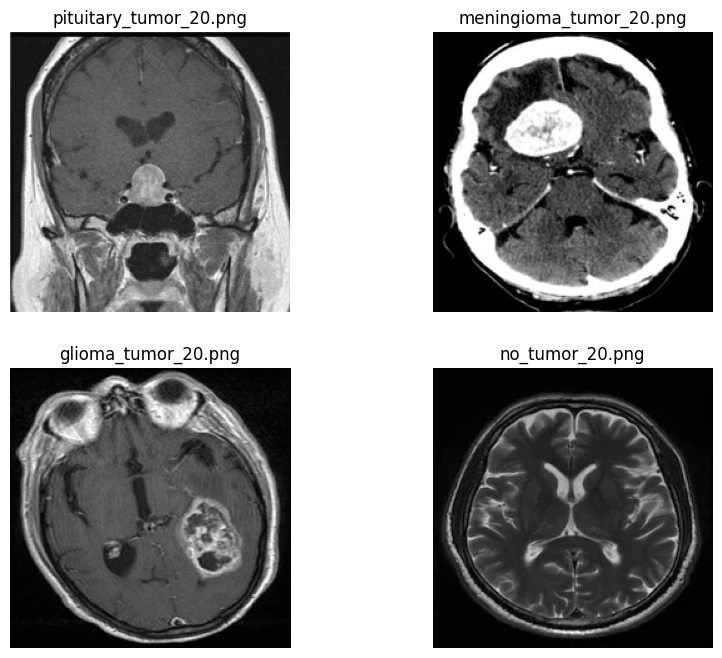

In [12]:
# create subplots

_, ax = plt.subplots(nrows=len(image_paths_map) // 2, ncols=2, figsize=(10, 8))
axes = ax.reshape(-1)

# get image at specified index
for i, (_, image_paths) in enumerate(image_paths_map.items()):
    for path in image_paths:
        if path.endswith(f"{image_index}.png"):
            break

    # plot each image in subplots
    plot_image(axes[i], path)

In [13]:
dataset = image_dataset_from_directory(
    "data",
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    seed=1,
    image_size=(224, 224),
    batch_size=1,
)

Found 394 files belonging to 4 classes.


Create image vector embeddings
- using pretrained model ResNet50, a popular model for image classification

In [14]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("KxSystems/mri_resnet_model")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/43.7k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/572k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/283M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 16392     
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 23604140 (90.04 MB)
Trainable params: 23551020 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


We can see that the model has four layers: ResNet-50, Flatten, and two Dense layers. The ResNet-50 "layer" is really many layers, abstracted under one name. This is why it contains millions of parameters. The Flatten layer does not contain any parameters - its sole purpose is to "flatten" the outputs of ResNet-50 into a 2048-dimensional vector, known as a feature vector. The final two Dense layers transform the ResNet-50 feature vector into a 4-dimensional classification of the input image.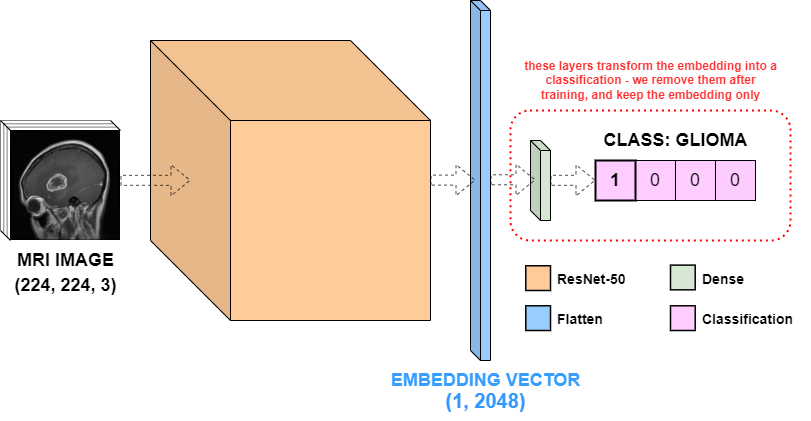

Although the Dense layers were essential for training ResNet-50 to classify our four brain tumor classes, we will no longer be needing them. In this example, we are interested in the embedding, not the classification output. Therefore, we will remove the last two layers of the pre-trained model by calling pop(). This means that the new output of the model is the 2048-dimensional feature vector - the ResNet-50 embedding of the input image.



In [16]:
model.pop()
model.pop()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


Create embeddings

In [17]:
!pip install langchain-cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: 

In [18]:
os.environ["COHERE_API_KEY"] = (
    os.environ["COHERE_API_KEY"]
    if "COHERE_API_KEY" in os.environ
    else getpass("Cohere API Token: ")
)

Cohere API Token: ··········


In [20]:
from langchain_cohere import CohereEmbeddings

In [19]:
# create empty arrays to store the embeddings and labels
embeddings = np.empty([len(dataset), 2048])

labels = np.empty([len(dataset), 4])

In [21]:
# for each image in dataset, get its embedding and class label
for i, image in tqdm(enumerate(dataset), total=len(dataset)):
    embeddings[i, :] = model.predict(image[0], verbose=0)
    labels[i, :] = image[1]

  0%|          | 0/394 [00:00<?, ?it/s]

In [22]:
# list the tumor types in sorted order
tumor_types = sorted(image_paths_map.keys())

In [23]:
# for each vector, save the tumor type given by the high index
class_labels = [tumor_types[label.argmax()] for label in labels]

##### Define Image File Paths

It is often useful to save the entire filepath of the image, rather than just its name. In the cell below, we iterate through the files and save their filepaths.

In [24]:
# get a single list of all paths
all_paths = []
for _, image_paths in image_paths_map.items():
    all_paths += image_paths

In [25]:
sorted_all_paths = sorted(all_paths)

In [26]:
embedded_df = pd.DataFrame(
    {
        "source": sorted_all_paths,
        "class": class_labels,
        "embedding": embeddings.tolist(),
    }
)

In [27]:
show_df(embedded_df)

(394, 3)


,source,class,embedding
0,./data/glioma_tumor/glioma_tumor_0.png,glioma_tumor,"[0.0, 1.3172647953033447, 0.20154626667499542,..."
1,./data/glioma_tumor/glioma_tumor_1.png,glioma_tumor,"[0.10450773686170578, 0.5598100423812866, 0.87..."
2,./data/glioma_tumor/glioma_tumor_10.png,glioma_tumor,"[0.055571846663951874, 1.653620719909668, 1.16..."
3,./data/glioma_tumor/glioma_tumor_11.png,glioma_tumor,"[0.7401725649833679, 0.631066620349884, 0.3245..."
4,./data/glioma_tumor/glioma_tumor_12.png,glioma_tumor,"[0.2181936800479889, 0.19898554682731628, 0.01..."


In [28]:
_umap = umap.UMAP(n_neighbors=15, min_dist=0.0)

In [29]:
umap_df = pd.DataFrame(_umap.fit_transform(embeddings), columns=["u0", "u1"])

In [30]:
show_df(umap_df)

(394, 2)


,u0,u1
0,8.883273,10.701911
1,17.590488,16.655243
2,8.829738,10.795631
3,8.594945,8.285290
4,8.906646,10.925912


In [31]:
# define color for each class label
class_colors = ["blue", "red", "green", "purple"]

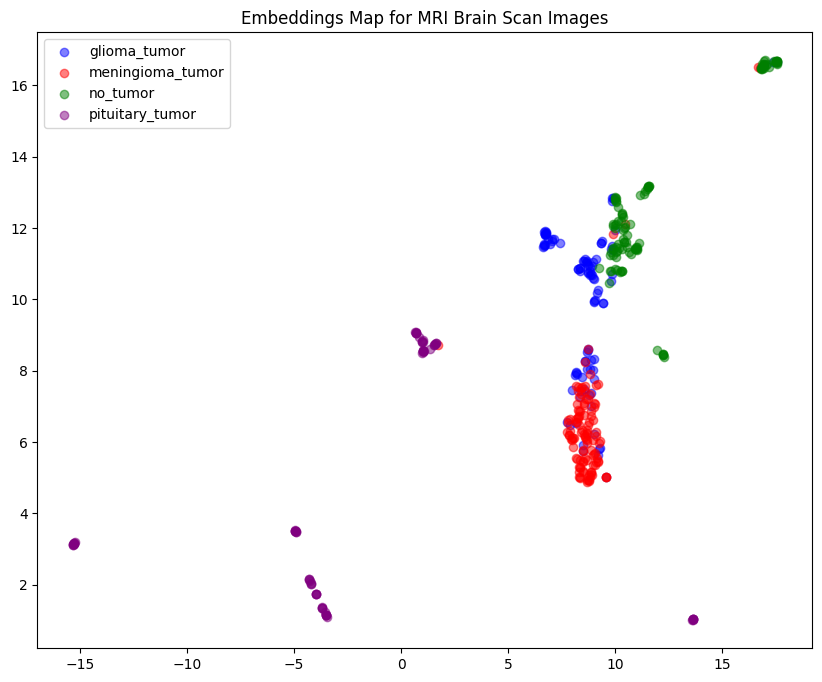

In [32]:
# Create a figure for plotting
plt.figure(figsize=(10, 8))

# Scatter plot with 'u0' and 'u1' columns as x and y, color mapped by class_labels
for tumor_type, color in zip(tumor_types, class_colors):
    indices_to_plot = [i for i, label in enumerate(class_labels) if label == tumor_type]
    subset = umap_df.iloc[indices_to_plot]
    plt.scatter(subset["u0"], subset["u1"], label=tumor_type, color=color, alpha=0.5)

# beutify plot
plt.title("Embeddings Map for MRI Brain Scan Images")
plt.legend()
plt.show()

In [33]:
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)

KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

KDB.AI endpoint: https://cloud.kdb.ai/instance/rrkogaklv6
KDB.AI API key: ··········


In [34]:
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

In [35]:
image_schema = {
    "columns": [
        {"name": "source", "pytype": "str"},
        {"name": "class", "pytype": "str"},
        {
            "name": "embedding",
            "vectorIndex": {"dims": 2048, "metric": "L2", "type": "hnsw"},
        },
    ]
}

In [36]:
# ensure the table does not already exist
try:
    session.table("mri").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [37]:
table = session.create_table("mri", image_schema)

In [38]:
# convert bytes to MB
embedded_df.memory_usage(deep=True).sum() / (1024**2)

6.2371368408203125

In [40]:
table.insert(embedded_df)

True

In [41]:
table.query()

,source,class,embedding
0,./data/glioma_tumor/glioma_tumor_0.png,glioma_tumor,"[0.0, 1.3172647953033447, 0.20154626667499542,..."
1,./data/glioma_tumor/glioma_tumor_1.png,glioma_tumor,"[0.10450773686170578, 0.5598100423812866, 0.87..."
2,./data/glioma_tumor/glioma_tumor_10.png,glioma_tumor,"[0.055571846663951874, 1.653620719909668, 1.16..."
3,./data/glioma_tumor/glioma_tumor_11.png,glioma_tumor,"[0.7401725649833679, 0.631066620349884, 0.3245..."
4,./data/glioma_tumor/glioma_tumor_12.png,glioma_tumor,"[0.2181936800479889, 0.19898554682731628, 0.01..."
...,...,...,...
389,./data/pituitary_tumor/pituitary_tumor_71.png,pituitary_tumor,"[0.15349969267845154, 1.7610543966293335, 1.46..."
390,./data/pituitary_tumor/pituitary_tumor_72.png,pituitary_tumor,"[0.15349969267845154, 1.7610543966293335, 1.46..."
391,./data/pituitary_tumor/pituitary_tumor_73.png,pituitary_tumor,"[0.0, 1.1767884492874146, 1.2333394289016724, ..."
392,./data/pituitary_tumor/pituitary_tumor_8.png,pituitary_tumor,"[0.36798161268234253, 0.07278980314731598, 0.0..."


In [42]:
table.query(filter=[("like", "class", "*glioma_tumor*")])

,source,class,embedding
0,./data/glioma_tumor/glioma_tumor_0.png,glioma_tumor,"[0.0, 1.3172647953033447, 0.20154626667499542,..."
1,./data/glioma_tumor/glioma_tumor_1.png,glioma_tumor,"[0.10450773686170578, 0.5598100423812866, 0.87..."
2,./data/glioma_tumor/glioma_tumor_10.png,glioma_tumor,"[0.055571846663951874, 1.653620719909668, 1.16..."
3,./data/glioma_tumor/glioma_tumor_11.png,glioma_tumor,"[0.7401725649833679, 0.631066620349884, 0.3245..."
4,./data/glioma_tumor/glioma_tumor_12.png,glioma_tumor,"[0.2181936800479889, 0.19898554682731628, 0.01..."
...,...,...,...
95,./data/glioma_tumor/glioma_tumor_95.png,glioma_tumor,"[0.6331989765167236, 0.5156585574150085, 0.037..."
96,./data/glioma_tumor/glioma_tumor_96.png,glioma_tumor,"[1.1890074014663696, 0.10027790069580078, 0.25..."
97,./data/glioma_tumor/glioma_tumor_97.png,glioma_tumor,"[0.5289318561553955, 0.3764987885951996, 0.011..."
98,./data/glioma_tumor/glioma_tumor_98.png,glioma_tumor,"[1.0254502296447754, 0.8127467632293701, 0.083..."


In [43]:
random_row_index_1 = 40

In [44]:
random_row_1 = embedded_df.iloc[random_row_index_1]

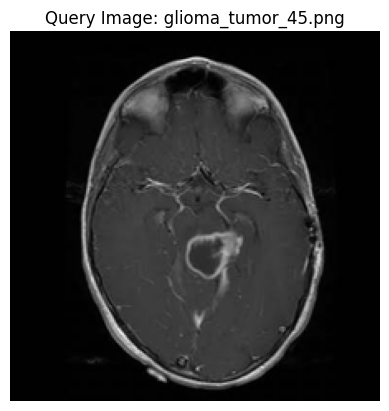

In [45]:
plot_image(plt.subplots()[-1], random_row_1["source"], label="Query Image")

In [46]:
sample_embedding_1 = random_row_1["embedding"]

In [47]:
results_1 = table.search([sample_embedding_1], n=9)
results_1[0]

,source,class,embedding,__nn_distance
0,./data/glioma_tumor/glioma_tumor_45.png,glioma_tumor,"[0.6581201553344727, 0.7380955219268799, 0.374...",0.000000
1,./data/glioma_tumor/glioma_tumor_71.png,glioma_tumor,"[0.5400820970535278, 0.6335980296134949, 0.327...",655.003418
2,./data/glioma_tumor/glioma_tumor_61.png,glioma_tumor,"[1.1261743307113647, 1.0511529445648193, 0.607...",695.868896
3,./data/glioma_tumor/glioma_tumor_95.png,glioma_tumor,"[0.6331989765167236, 0.5156585574150085, 0.037...",709.470337
4,./data/glioma_tumor/glioma_tumor_68.png,glioma_tumor,"[0.5686517357826233, 1.2953144311904907, 0.092...",714.166443
5,./data/glioma_tumor/glioma_tumor_41.png,glioma_tumor,"[0.14557042717933655, 0.7579464912414551, 1.33...",716.417358
6,./data/glioma_tumor/glioma_tumor_46.png,glioma_tumor,"[1.7890290021896362, 0.4724000096321106, 0.271...",734.459473
7,./data/glioma_tumor/glioma_tumor_12.png,glioma_tumor,"[0.2181936800479889, 0.19898554682731628, 0.01...",751.183716
8,./data/glioma_tumor/glioma_tumor_15.png,glioma_tumor,"[0.7461268305778503, 1.3112188577651978, 0.506...",761.760132


In [48]:
def plot_test_result_with_8NN(test_file: str, neighbors: pd.Series) -> None:
    # create figure
    _, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
    axes = ax.reshape(-1)

    # plot query image
    plot_image(axes[0], test_file, "Test")

    # plot nearest neighbors
    for i, (_, value) in enumerate(neighbors.items(), start=1):
        plot_image(axes[i], value, f"{i}-NN")

In [49]:
nn1_filenames = results_1[0][1:]['source']

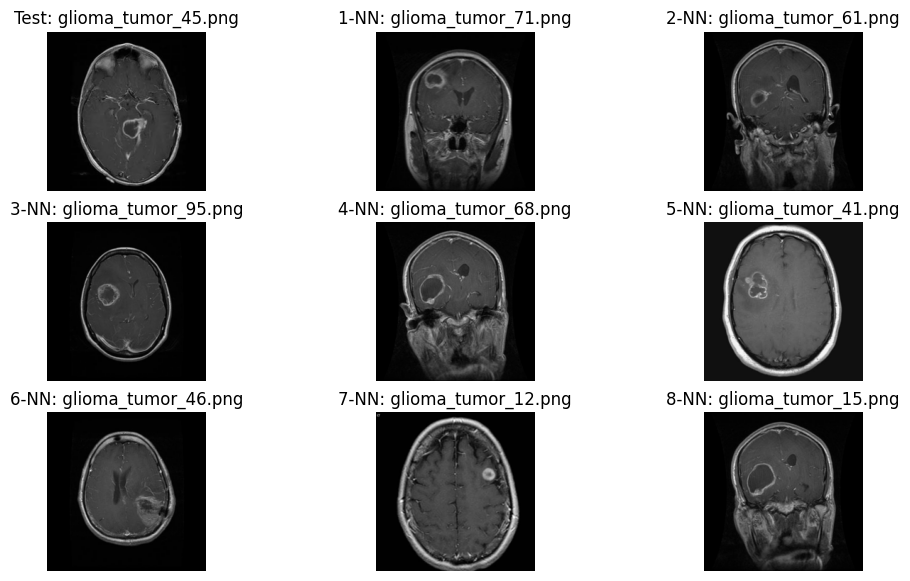

In [50]:
plot_test_result_with_8NN(test_file=random_row_1["source"], neighbors=nn1_filenames)

Automate the process

In [51]:
def mri_image_nn_search(table, df: pd.DataFrame, row_index: int) -> None:
    # Select the random row and the desired column's value
    row = df.iloc[row_index]

    # get the embedding from this row
    row_embedding = row["embedding"]

    # search for 8 nearest neighbors (exclude self)
    nn_results = table.search([row_embedding], n=9)[0][1:]

    # plot the neighbors
    plot_test_result_with_8NN(row["source"], nn_results["source"])

In [52]:
random_row_index_2 = 320

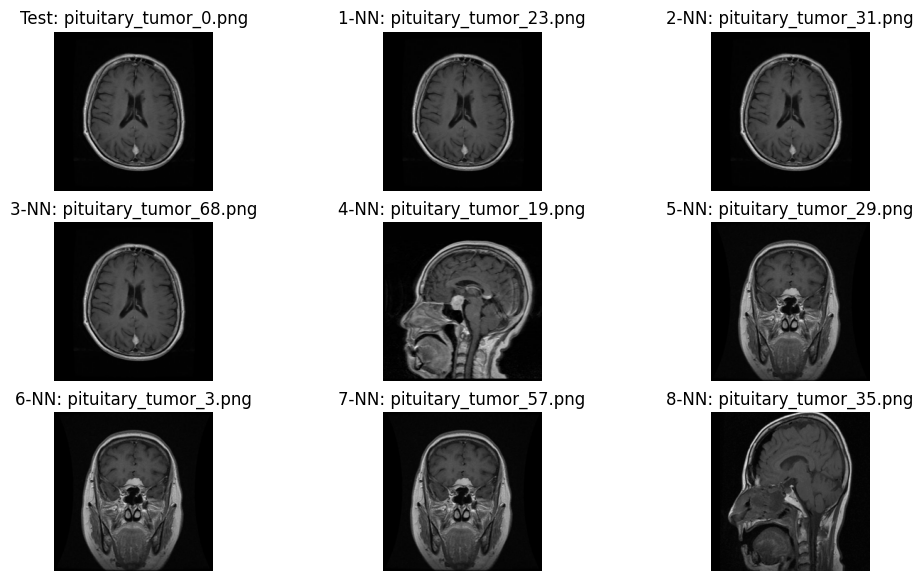

In [53]:
mri_image_nn_search(table, embedded_df, random_row_index_2)

In [54]:
table.drop()

True